<h2>第六章 機械学習

本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

In [16]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
# !unzip NewsAggregatorDataset.zip

In [17]:
# # 行数の確認
# !wc -l ./data/NewsAggregatorDataset/newsCorpora_re.csv
# # 先頭10行の確認
# !head -10 ./data/NewsAggregatorDataset/newsCorpora_re.csv

<h3>50: News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

GitHubには100MBしかアップロードできないので、少しnewsCorpora.csvを削りました。

In [18]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
# !sed -e 's/"/'\''/g' ./data/NewsAggregatorDataset/newsCorpora.csv > ./data/NewsAggregatorDataset/newsCorpora_re.csv

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
# データの読み込み
df = pd.read_csv('data/NewsAggregatorDataset/newsCorpora_re.csv', header=None, sep='\t')
df.columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']

# データの抽出
publisher_lst = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
df = df.query("PUBLISHER in @publisher_lst").filter(["TITLE", "CATEGORY"])

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# データの保存
train.to_csv('./data/NewsAggregatorDataset/train.txt', sep='\t', index=False)
valid.to_csv('./data/NewsAggregatorDataset/valid.txt', sep='\t', index=False)
test.to_csv('./data/NewsAggregatorDataset/test.txt', sep='\t', index=False)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())


【学習データ】
b    4374
e    4102
t    1180
m     713
Name: CATEGORY, dtype: int64
【検証データ】
b    547
e    513
t    147
m     89
Name: CATEGORY, dtype: int64
【評価データ】
b    547
e    513
t    148
m     89
Name: CATEGORY, dtype: int64


<h3>51: 学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

前処理

In [20]:
import string
import re
import pandas as pd
from sklearn.model_selection import train_test_split
# 最初と同じ処理
df = pd.read_csv('data/NewsAggregatorDataset/newsCorpora_re.csv', header=None, sep='\t')
df.columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
publisher_lst = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
df = df.query("PUBLISHER in @publisher_lst").filter(["TITLE", "CATEGORY"])
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

def preprocessing(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(table)  # 記号をスペースに置換
  text = text.lower()  # 小文字化
  text = re.sub('[0-9]+', '0', text)  # 数字列を0に置換

  return text

# データの再結合
df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True)  # indexを振りなおす
df["TITLE"] = df["TITLE"].apply(preprocessing)
df.head()

,TITLE,CATEGORY
0,update 0 softbank ceo sees new movement hope...,t
1,yahoo owns a 0percent stake in alibaba and cas...,t
2,wayne knight is alive seinfeld actor tweets...,e
3,mark ruffalo implies ben affleck ruined friend...,e
4,lindsay lohan admits she s single as she guest...,e


記事の見出しをスペースで分割した単語群を対象にTF-IDFを算出し、その値を特徴量として利用することにします。また、1単語(uni-gram)だけでなく連続する2単語(bi-gram)についてもTF-IDFを計算します。

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# データの分割
train_valid = df[:len(train) + len(valid)]
test = df[len(train) + len(valid):]

# TfidfVectorizer
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))  # ngram_rangeでTF-IDFを計算する単語の長さを指定

# ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])  # testの情報は使わない
X_test = vec_tfidf.transform(test['TITLE'])

# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names())

# データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]

# データの保存
# X_train.to_csv('./data/NewsAggregatorDataset/X_train.txt', sep='\t', index=False)
# X_valid.to_csv('./data/NewsAggregatorDataset/X_valid.txt', sep='\t', index=False)
# X_test.to_csv('./data/NewsAggregatorDataset/X_test.txt', sep='\t', index=False)

print(X_train.head())

    0m  0million  0nd   0s  0st  0th  0th birthday   aa  aaliyah  abbvie  ...  \
0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0      0.0     0.0  ...   
1  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0      0.0     0.0  ...   
2  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0      0.0     0.0  ...   
3  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0      0.0     0.0  ...   
4  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0      0.0     0.0  ...   

   young  your  your mother   yr  yr high  yuan  zac  zac efron  zendaya  zone  
0    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
1    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
2    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
3    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
4    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  

[5 rows x 2745 columns]


<h3>52: 51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [22]:
from sklearn.linear_model import LogisticRegression

# モデルの学習
model = LogisticRegression(random_state=123, max_iter=10000)
model.fit(X_train, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=123)

<h3>53: 52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．



In [23]:
import numpy as np

def score_lg(model, X):
  return [np.max(model.predict_proba(X), axis=1), model.predict(X)]

train_pred = score_lg(model, X_train)
test_pred = score_lg(model, X_test)

print(train_pred)

[array([0.6115821 , 0.73930633, 0.8577146 , ..., 0.75845577, 0.89905132,
       0.95736828]), array(['b', 'b', 'e', ..., 'b', 'e', 'e'], dtype=object)]


<h3>54: 52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [24]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])
print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.926
正解率（評価データ）：0.876


<h3>55: 52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

[[4229   83    8   54]
 [  54 4038    4    6]
 [  90  113  497   13]
 [ 186  145    8  841]]


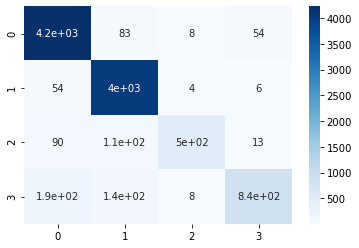

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 学習データ
train_cm = confusion_matrix(train['CATEGORY'], train_pred[1])
print(train_cm)
sns.heatmap(train_cm, annot=True, cmap='Blues')
plt.show()


[[514  20   1  12]
 [ 13 497   0   3]
 [ 16  26  42   5]
 [ 45  19   1  83]]


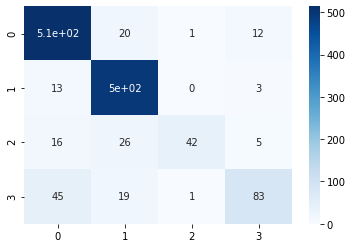

In [26]:
# 評価データ
test_cm = confusion_matrix(test['CATEGORY'], test_pred[1])
print(test_cm)
sns.heatmap(test_cm, annot=True, cmap='Blues')
plt.show()

<h3>56: 52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_scores(y_true, y_pred):
  # 適合率
  precision = precision_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])  # Noneを指定するとクラスごとの精度をndarrayで返す
  precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  # 末尾にマイクロ平均を追加
  precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  # 末尾にマクロ平均を追加

  # 再現率
  recall = recall_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
  recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
  recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # F1スコア
  f1 = f1_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
  f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
  f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # 結果を結合してデータフレーム化
  scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

  return scores

print(calculate_scores(test['CATEGORY'], test_pred[1]))

             適合率       再現率     F1スコア
b       0.874150  0.939671  0.905727
e       0.884342  0.968811  0.924651
t       0.805825  0.560811  0.661355
m       0.954545  0.471910  0.631579
マイクロ平均  0.875867  0.875867  0.875867
マクロ平均   0.879715  0.735301  0.780828


<h3>57: 52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [28]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(model.classes_, model.coef_):
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,bank,fed,ecb,china,stocks,obamacare,euro,yellen,ukraine,oil
重要度下位,her,ebola,video,microsoft,the,google,and,she,virus,fda




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,movie,star,her,film,kim,paul,george,she
重要度下位,update,us,google,study,china,gm,facebook,says,apple,billion




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,study,cancer,drug,fda,mers,cdc,cases,health,could
重要度下位,facebook,gm,google,ceo,apple,amazon,bank,sales,deal,tv




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,microsoft,climate,gm,tesla,nasa,comcast,fcc
重要度下位,stocks,fed,cancer,men,drug,american,ukraine,percent,still,her


<h3>58: ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [29]:
from tqdm import tqdm
import numpy as np

result = []
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
  # モデルの学習
  lg = LogisticRegression(random_state=123, max_iter=10000, C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  train_pred = score_lg(lg, X_train)
  valid_pred = score_lg(lg, X_valid)
  test_pred = score_lg(lg, X_test)

  # 正解率の算出
  train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])
  test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])

  # 結果の格納
  result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [02:13<00:00, 13.34s/it]


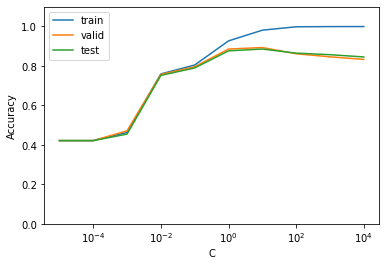

In [30]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

<h3>59: 学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

実行に時間がかかりすぎるので省略します。

In [31]:
import optuna

# 最適化対象を関数で指定
def objective_lg(trial):
  # チューニング対象パラメータのセット
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
  C = trial.suggest_loguniform('C', 1e-4, 1e4)

  # モデルの学習
  lg = LogisticRegression(random_state=123, 
                          max_iter=10000, 
                          penalty='elasticnet', 
                          solver='saga', 
                          l1_ratio=l1_ratio, 
                          C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  valid_pred = score_lg(lg, X_valid)

  # 正解率の算出
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])    

  return valid_accuracy 

# 最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective_lg, timeout=3600)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))


[I 2023-07-26 02:49:23,669] A new study created in memory with name: no-name-b0e99b96-c6ee-4be6-95ae-2a13b75c7e05
<ipython-input-31-215093586d99>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
<ipython-input-31-215093586d99>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e4)


探索したパラメータで再度モデルを学習し、正解率を確認します。

In [ ]:
# パラメータの設定
l1_ratio = trial.params['l1_ratio']
C = trial.params['C']

# モデルの学習
lg = LogisticRegression(random_state=123, 
                        max_iter=10000, 
                        penalty='elasticnet', 
                        solver='saga', 
                        l1_ratio=l1_ratio, 
                        C=C)
lg.fit(X_train, train['CATEGORY'])

# 予測値の取得
train_pred = score_lg(lg, X_train)
valid_pred = score_lg(lg, X_valid)
test_pred = score_lg(lg, X_test)

# 正解率の算出
train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1]) 
valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1]) 
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1]) 

print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（検証データ）：{valid_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

NameError: name 'trial' is not defined